Mount drive for file access

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Import libraries

In [ ]:
import os
from os import listdir
from os.path import isfile, join
import nibabel as nib
import imageio
import numpy as np
import torch
from torchvision.utils import save_image
import torchvision.transforms.v2.functional as TF
import matplotlib.pyplot as plt
from PIL import Image

Check for compute devices (cpu/gpu)

In [ ]:
torch.manual_seed(13)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Read in .nii files

In [ ]:
data_dir = "U-Net/data/NIFTIs_03"

Explore NiBabel library to access and present nii data in understandable fashion

In [ ]:
data_nii = nib.load(os.path.join(data_dir, "040114N", "040114_19010405_AX_T1_FL3D_img.nii"))
data_msk_nii = nib.load(os.path.join(data_dir, "040114N", "040114_19010405_AX_T1_FL3D_msk.nii"))

Understand types and shapes of NII data

In [ ]:
data_img = data_nii.get_fdata()
print("NII image type is: ", data_img.dtype)
print("NII image shape is: ", data_img.shape)

data_msk_img = data_msk_nii.get_fdata()
print("NII mask image type is: ", data_msk_img.dtype)
print("NII mask image shape is: ", data_msk_img.shape)

NII image type is:  float64
NII image shape is:  (512, 512, 120)
NII mask image type is:  float64
NII mask image shape is:  (512, 512, 120)


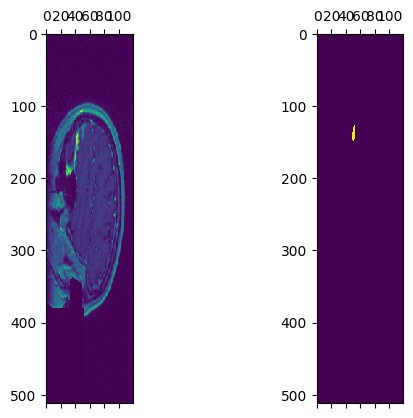

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(data_img[350, :, :])
ax[1].matshow(data_msk_img[350, :, :])

Check all files for their resolution to see if they're easily compatible with 512x512 input size of U-Net

In [ ]:
data_files = []
data_subdirs = sorted(list(os.walk(data_dir)))

for i in range(1, len(data_subdirs)):
  for j in range(len(data_subdirs[i][2])):
    data_files.append( join(data_subdirs[i][0], sorted(data_subdirs[i][2])[j]) )

print(f"There are {len(data_files)} files")

In [ ]:
for idx in range(0, len(data_files), 2):
  # Double check data_files[idx] contains all necessary file location information
  train_img = nib.load(join(data_dir, data_files[idx])).get_fdata()

  print(f"{data_files[idx]}: {train_img.shape}")

*** Discoloration occurs around timeslice 185,186 where segmentation transforms from monochromatic yellow to a greenish yellow mixture ***

In [ ]:
data_img = nib.load(os.path.join(data_dir, "040102_19000414_Sag_CUBE_T1_FS_img.nii")).get_fdata()
data_msk_img = nib.load(os.path.join(data_dir, "040102_19000414_Sag_CUBE_T1_FS_msk.nii")).get_fdata()

In [ ]:
# 1150 = 6*ts+(4)

In [ ]:
ts = 186

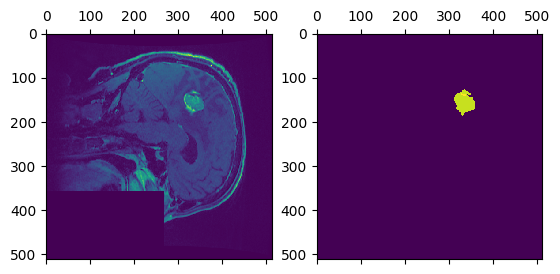

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(data_img[ts, :, :])
ax[1].matshow(data_msk_img[ts, :, :])

All training images' max pixel values

In [ ]:
data_files

['040102_19000414_Sag_CUBE_T1_FS_img.nii',
 '040102_19000414_Sag_CUBE_T1_FS_msk.nii',
 '040102_19010517_Sag_CUBE_T1_FS_img.nii',
 '040102_19010517_Sag_CUBE_T1_FS_msk.nii',
 '040102_19010811_Sag_CUBE_T1_FS_img.nii',
 '040102_19010811_Sag_CUBE_T1_FS_msk.nii']

In [ ]:
data_img = nib.load(os.path.join(data_dir, "040102_19000414_Sag_CUBE_T1_FS_img.nii")).get_fdata()

global_max, global_min = 0,100
for idx in range(data_img.shape[0]):
  curr_img = data_img[idx,:,:]
  global_max = max(global_max, curr_img.max())
  global_min = min(global_min, curr_img.min())

print(global_max)
print(global_min)

1983.0
0.0


In [ ]:
data_img = nib.load(os.path.join(data_dir, "040102_19010517_Sag_CUBE_T1_FS_img.nii")).get_fdata()

global_max, global_min = 0,100
for idx in range(data_img.shape[0]):
  curr_img = data_img[idx,:,:]
  global_max = max(global_max, curr_img.max())
  global_min = min(global_min, curr_img.min())

print(global_max)
print(global_min)

1894.0
0.0


In [ ]:
data_img = nib.load(os.path.join(data_dir, "040102_19010811_Sag_CUBE_T1_FS_img.nii")).get_fdata()

global_max, global_min = 0,100
for idx in range(data_img.shape[0]):
  curr_img = data_img[idx,:,:]
  global_max = max(global_max, curr_img.max())
  global_min = min(global_min, curr_img.min())

print(global_max)
print(global_min)

1940.0
0.0


All mask images' max pixel values

In [ ]:
data_msk_img = nib.load(os.path.join(data_dir, "040102_19000414_Sag_CUBE_T1_FS_msk.nii")).get_fdata()

global_max, global_min = 0,100
for idx in range(data_msk_img.shape[0]):
  curr_img = data_msk_img[idx,:,:]
  global_max = max(global_max, curr_img.max())
  global_min = min(global_min, curr_img.min())

print(global_max)
print(global_min)

12.0
0.0


In [ ]:
data_msk_img = nib.load(os.path.join(data_dir, "040102_19010517_Sag_CUBE_T1_FS_msk.nii")).get_fdata()

global_max, global_min = 0,100
for idx in range(data_msk_img.shape[0]):
  curr_img = data_msk_img[idx,:,:]
  global_max = max(global_max, curr_img.max())
  global_min = min(global_min, curr_img.min())

print(global_max)
print(global_min)

22.0
0.0


In [ ]:
data_msk_img = nib.load(os.path.join(data_dir, "040102_19010811_Sag_CUBE_T1_FS_msk.nii")).get_fdata()

global_max, global_min = 0,100
for idx in range(data_msk_img.shape[0]):
  curr_img = data_msk_img[idx,:,:]
  global_max = max(global_max, curr_img.max())
  global_min = min(global_min, curr_img.min())

print(global_max)
print(global_min)

22.0
0.0


Only files within the 040102N subfolder have 512x512 resolution

Use two files for training -> other file will be used for testing

Rewrite data directory now that we've discovered only one subfolder is compatible with our U-Net input resolution

In [ ]:
data_dir = "U-Net/data/NIFTIs_03/040102N"

Helper function to name saved image files

In [ ]:
def pad_int(run_id, zfill=4):
  # pad id number to 4 digits
  return str(run_id).zfill(zfill)

def get_fname(fnumber, img_bool):
  fnum = pad_int(fnumber)
  return f"{fnum}_img.png" if img_bool else f"{fnum}_msk.png"

Train file 1: 168-225 (green/yellow)

Train file 2: 452-497, 526-574 (green/yellow)
(offset by 352)

Test file: 98-142, 172-227 (green/yellow)

When saving masks via PIL (mode "P") discoloration of images becomes bluish. We can save all images via matplotlib instead. Re-open images saved via matplotlib to double check issue doesn't arise again.

In [ ]:
# Open up saved image to double check compatibility
padded_idx = pad_int(16) # 186 was original

img_name = join(save_img_dir, f"{padded_idx}_img.png")
mask_name = join(save_img_dir, f"{padded_idx}_msk.png")
with Image.open(img_name) as image:
  image.load()
with Image.open(mask_name) as mask:
  mask.load()

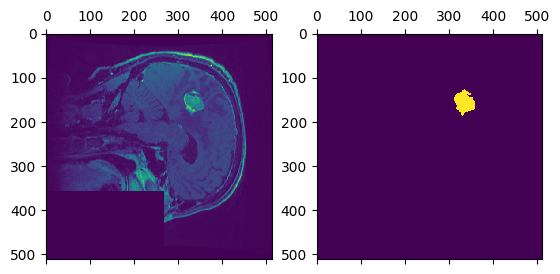

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].matshow(image)
ax[1].matshow(mask)

In [ ]:
import torchvision
from torchvision.transforms import v2
#torch_image = torchvision.transforms.functional.pil_to_tensor(image.convert("RGB"))
#torch_mask = torchvision.transforms.functional.pil_to_tensor(mask.convert("P"))

torch_tf = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
        ])
torch_image = torch_tf(image.convert("RGB"))
torch_mask = torch_tf(mask.convert("P"))

View maximum image pixel values for image and mask without segmentations

In [ ]:
print(torch_image.shape)
print(torch_mask.shape)

print(torch.max(torch_image))
print(torch.min(torch_image))
print(torch.max(torch_mask))
print(torch.min(torch_mask))

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
tensor(0.9922)
tensor(0.0039)
tensor(0.)
tensor(0.)


Same as above but for masks with segmentations

In [ ]:
print(torch_image.shape)
print(torch_mask.shape)

print(torch.max(torch_image))
print(torch.min(torch_image))
print(torch.max(torch_mask))
print(torch.min(torch_mask))

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
tensor(0.9922)
tensor(0.0039)
tensor(0.0039)
tensor(0.)


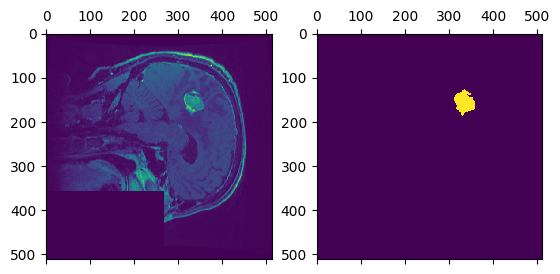

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].matshow(torch_image.permute(1,2,0))
ax[1].matshow(torch_mask.permute(1,2,0))

In [ ]:
def rescale(x, old_range, new_range, clamp=False,):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min

    if clamp:
        x = x.clamp(new_min, new_max)
    return x

In [ ]:
torch_image = rescale(torch_image, (torch.min(torch_image).item(),1), (-1,1), clamp=True)
torch_mask = rescale(torch_mask, (0,torch.max(torch_mask).item()), (0,1))

print(torch.max(torch_image))
print(torch.min(torch_image))
print(torch.max(torch_mask))
print(torch.min(torch_mask))

tensor(0.9843)
tensor(-1.)
tensor(1.)
tensor(0.)


In [ ]:
torch_image = rescale(torch_image, (0,1), (-1,1), clamp=True)
torch_mask = rescale(torch_mask, (0,torch.max(torch_mask).item()), (0,1))

print(torch.max(torch_image))
print(torch.min(torch_image))
print(torch.max(torch_mask))
print(torch.min(torch_mask))

tensor(0.9843)
tensor(-0.9922)
tensor(1.)
tensor(0.)


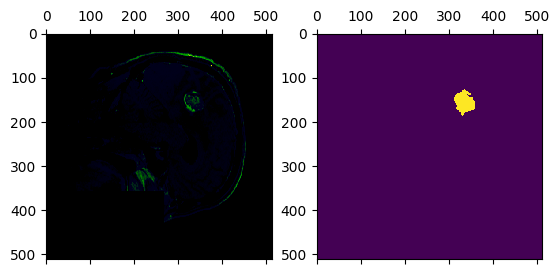

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].matshow(torch_image.permute(1,2,0))
ax[1].matshow(torch_mask.permute(1,2,0))